In [ ]:
pip install skorch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
#from skopt import forest_minimize
# from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#reading train data
TEP_FaultFree_Training = "/content/drive/MyDrive/ELEG817-Large scale ML/Project/TEP_FaultFree_Training.csv"
TEP_Faulty_Training = "/content/drive/MyDrive/ELEG817-Large scale ML/Project/TEP_Faulty_Training.csv"

#Reading test data
TEP_FaultFree_Testing = "/content/drive/MyDrive/ELEG817-Large scale ML/Project/TEP_FaultFree_Testing.csv"
TEP_Faulty_Testing = "/content/drive/MyDrive/ELEG817-Large scale ML/Project/TEP_Faulty_Testing.csv"

In [ ]:
# Specify your sampling logic function
def sampling_logic(chunk):
    # Get every other row
    return chunk.iloc[::20]

# Read the dataset in chunks and sample every other row
chunk_size = 10000  # Memory constraints
sampled_data_TEP_train_nofaults = pd.DataFrame()

# Open the CSV dataset file
dataset = pd.read_csv(TEP_FaultFree_Training, chunksize=chunk_size, dtype='float32')

# Loop through the dataset in chunks
for chunk_df in dataset:
    # Apply sampling logic to the chunk
    sampled_chunk = sampling_logic(chunk_df)

    # Concatenate the sampled chunk to the result
    sampled_data_TEP_train_nofaults = pd.concat([sampled_data_TEP_train_nofaults, sampled_chunk])


In [ ]:
sampled_data_TEP_train_nofaults.shape

(12500, 55)

In [ ]:
# Sampling
def sampling_logic(chunk):
    # Get every other row
    return chunk.iloc[::20]

# Read the dataset in chunks
chunk_size = 10000  # Memory constraints
sampled_data_TEP_train_faults = pd.DataFrame()

# Open the CSV dataset file
dataset = pd.read_csv(TEP_Faulty_Training, chunksize=chunk_size, dtype='float32')

# Loop through the dataset in chunks
for chunk_df in dataset:
    # Apply sampling logic to the chunk
    sampled_chunk = sampling_logic(chunk_df)

    # Concatenate the sampled chunk to the result
    sampled_data_TEP_train_faults = pd.concat([sampled_data_TEP_train_faults, sampled_chunk])

In [ ]:
sampled_data_TEP_train_faults.shape

(250000, 55)

In [ ]:
# Sampling
def sampling_logic(chunk):
    # Get every other row
    return chunk.iloc[::20]

# Read the dataset in chunks
chunk_size = 10000  # Memory constraints
sampled_data_TEP_test_nofaults = pd.DataFrame()

# Open the CSV dataset file
dataset = pd.read_csv(TEP_FaultFree_Testing, chunksize=chunk_size, dtype='float32')

# Loop through the dataset in chunks
for chunk_df in dataset:
    # Apply sampling logic to the chunk
    sampled_chunk = sampling_logic(chunk_df)

    # Concatenate the sampled chunk to the result
    sampled_data_TEP_test_nofaults = pd.concat([sampled_data_TEP_test_nofaults, sampled_chunk])

In [ ]:
sampled_data_TEP_test_nofaults.shape

(24000, 55)

In [ ]:
# Specify your sampling logic function
def sampling_logic(chunk):
    # Get every other row
    return chunk.iloc[::20]

# Read the dataset in chunks and sample every other row
chunk_size = 10000  # Memory constraints
sampled_data_TEP_test_faults = pd.DataFrame()

# Open the CSV dataset file
dataset = pd.read_csv(TEP_Faulty_Testing, chunksize=chunk_size, dtype='float32')

# Loop through the dataset in chunks
for chunk_df in dataset:
    # Apply sampling logic to the chunk
    sampled_chunk = sampling_logic(chunk_df)

    # Concatenate the sampled chunk to the result
    sampled_data_TEP_test_faults = pd.concat([sampled_data_TEP_test_faults, sampled_chunk])

In [ ]:
sampled_data_TEP_test_faults.shape

(480000, 55)

In [ ]:
training_data = [sampled_data_TEP_train_nofaults, sampled_data_TEP_train_faults]
training_data_all = pd.concat(training_data)
training_data_all = training_data_all.sort_values(by=['faultNumber', 'simulationRun', 'sample'], ascending=True).reset_index(drop=True)

In [ ]:
testing_data = [sampled_data_TEP_test_nofaults, sampled_data_TEP_test_faults]
testing_data_all = pd.concat(testing_data)
testing_data_all = testing_data_all.sort_values(by=['faultNumber', 'simulationRun', 'sample'], ascending=True).reset_index(drop=True)

In [ ]:
#training_data_all.shape

In [ ]:
#training_data_all.head()

In [ ]:
# training_data_all.tail()

In [ ]:
#training_data_all.to_csv('training_data_all.csv', index=False)

In [ ]:
# testing_data_all.shape

In [ ]:
# testing_data_all.head()

In [ ]:
# testing_data_all.tail()

In [ ]:
#testing_data_all.to_csv('testing_data_all.csv', index=False)

In [ ]:
#Fault numbers 3, 9, and 5 need to be elimnated.
faults_to_remove = [3, 9, 15]

In [ ]:
training_data_all = training_data_all[~training_data_all['faultNumber'].isin(faults_to_remove)]

In [ ]:
testing_data_all = testing_data_all[~testing_data_all['faultNumber'].isin(faults_to_remove)]

In [ ]:
# Check unique labels after removing faults
#print((training_data_all['faultNumber']))

# Convert faultNumber labels to sequential integers
label_mapping = {fault: idx for idx, fault in enumerate(training_data_all['faultNumber'].unique())}

# Apply the label mapping to training and testing data
training_data_all['faultNumber'] = training_data_all['faultNumber'].map(label_mapping)
testing_data_all['faultNumber'] = testing_data_all['faultNumber'].map(label_mapping)

<ipython-input-27-cb43d2787674>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data_all['faultNumber'] = testing_data_all['faultNumber'].map(label_mapping)


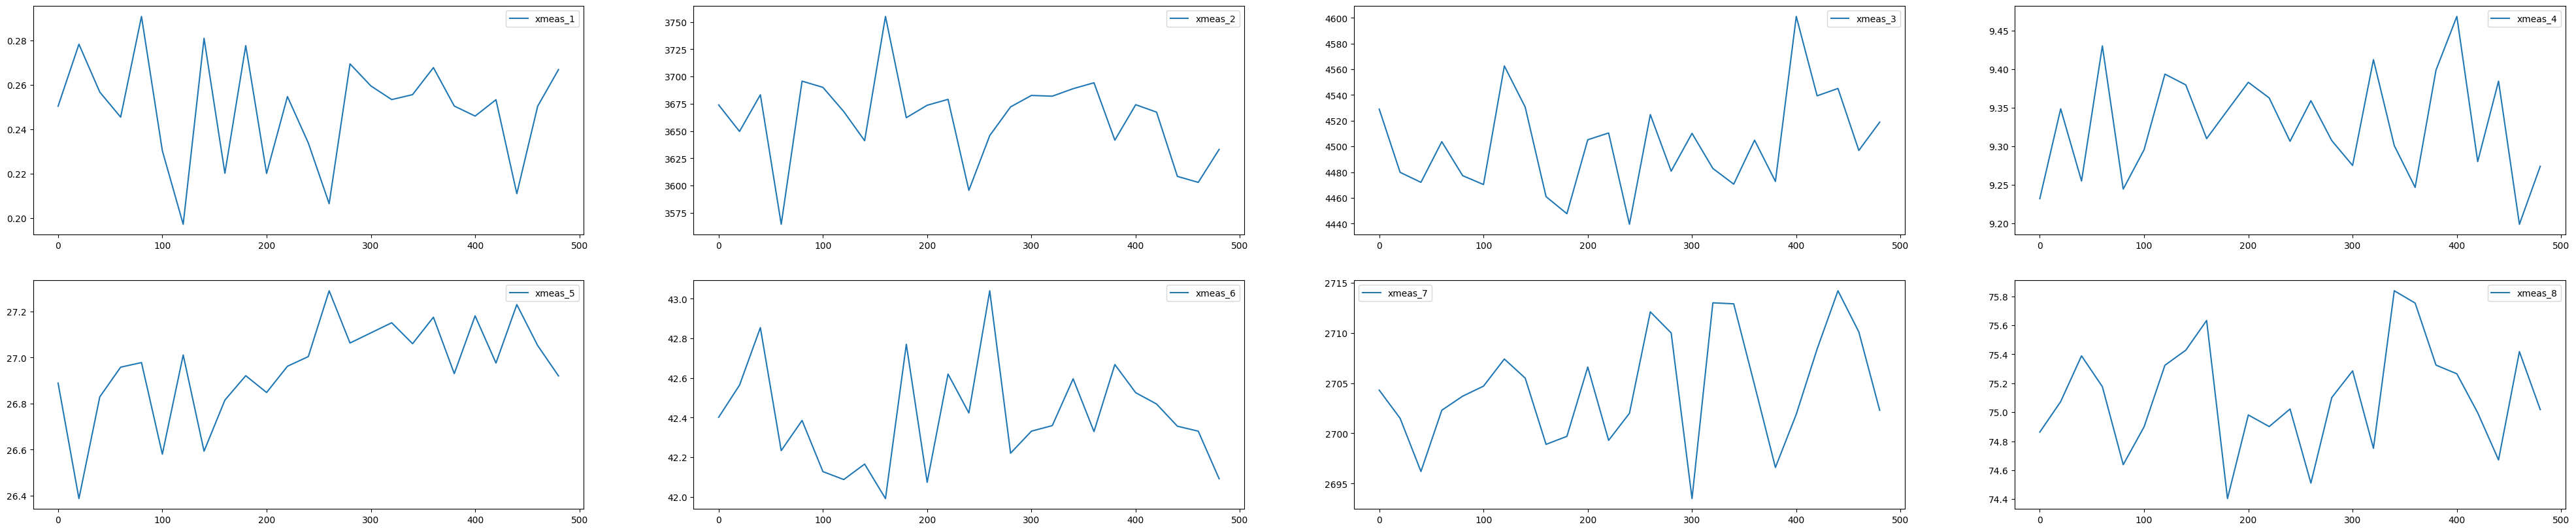

In [ ]:
df_train = sampled_data_TEP_train_nofaults[sampled_data_TEP_train_nofaults.simulationRun==1].iloc[:,3:11]

fig, ax = plt.subplots(2,4,figsize=(50,10))

for i in range(df_train.shape[1]):
    df_train.iloc[:,i].plot(ax=ax.ravel()[i])
    ax.ravel()[i].legend();

In [ ]:
new_column_names = [ '1_A_Feed',
                     '2_D_Feed',
                     '3_E_Feed',
                     '4_Total_Feed',
                     '5_Recycle_flow',
                     '6_Reactor_feed_rate',
                     '7_Reactor_pressure',
                     '8_Reactor_level',
                     '9_Reactor_temperature',
                     '10_Purge_rate',
                     '11_Separator_temperature',
                     '12_Separator_level',
                     '13_Separator_pressure',
                     '14_Separator_underflow',
                     '15_Stripper_level',
                     '16_Stripper_pressure',
                     '17_Stripper_underflow',
                     '18_Stripper_temperature',
                     '19_Stripper_steam_flow',
                     '20_Compressor_work',
                     '21_Reactor_cooling_water_outlet_temperature',
                     '22_Separator_cooling_water_outlet_temperature',
                     '23_Reactor_feed_component_A',
                     '24_Reactor_feed_component_B',
                     '25_Reactor_feed_component_C',
                     '26_Reactor_feed_component_D',
                     '27_Reactor_feed_component_E',
                     '28_Reactor_feed_component_F',
                     '29_Purge_component_A',
                     '30_Purge_component_B',
                     '31_Purge_component_C',
                     '32_Purge_component_D',
                     '33_Purge_component_E',
                     '34_Purge_component_F',
                     '35_Purge_component_G',
                     '36_Purge_component_H',
                     '37_Product_component_D',
                     '38_Product_component_E',
                     '39_Product_component_F',
                     '40_Product_component_G',
                     '41_Product_component_H',
                     '42_D_feed_flow',
                     '43_E_feed_flow',
                     '44_A_feed_flow',
                     '45_Total_feed_flow',
                     '46_Compressor_recycle_valve',
                     '47_Purge_valve',
                     '48_Separator_product_liquid_flow',
                     '49_Stripper_product_liquid_flow',
                     '50_Stripper_steam_valve',
                     '51_Reactor_cooling_water_flow',
                     '52_Condenser_cooling_water_flow']

#Changing the column names starting from the 3rd column
column_names_to_change = training_data_all.columns[3:]

#Array from the new column names
new_column_names_array = np.array(new_column_names)

# Update the DataFrame's column names
training_data_all.columns = np.concatenate([training_data_all.columns[:3], new_column_names_array])

# Print the updated DataFrame
training_data_all.head()

,faultNumber,simulationRun,sample,1_A_Feed,2_D_Feed,3_E_Feed,4_Total_Feed,5_Recycle_flow,6_Reactor_feed_rate,7_Reactor_pressure,...,43_E_feed_flow,44_A_feed_flow,45_Total_feed_flow,46_Compressor_recycle_valve,47_Purge_valve,48_Separator_product_liquid_flow,49_Stripper_product_liquid_flow,50_Stripper_steam_valve,51_Reactor_cooling_water_flow,52_Condenser_cooling_water_flow
0,0,1.0,1.0,0.25038,3674.000000,4529.000000,9.2320,26.889000,42.402000,2704.300049,...,53.743999,24.657000,62.543999,22.136999,39.935001,42.323002,47.757000,47.509998,41.257999,18.447001
1,0,1.0,21.0,0.27833,3649.699951,4479.899902,9.3486,26.386999,42.563999,2701.500000,...,53.946999,27.761000,60.589001,21.743000,39.397999,38.606998,46.686001,46.688000,41.584999,18.294001
2,0,1.0,41.0,0.25674,3683.300049,4472.100098,9.2549,26.829000,42.854000,2696.199951,...,54.049999,25.066999,62.834999,21.497999,41.471001,37.174999,43.987999,49.919998,41.145000,19.424999
3,0,1.0,61.0,0.24545,3564.600098,4503.700195,9.4303,26.958000,42.234001,2702.300049,...,53.265999,24.365999,59.139999,22.323000,42.512001,37.393002,44.616001,51.242001,40.164001,18.249001
4,0,1.0,81.0,0.29086,3695.800049,4477.299805,9.2444,26.978001,42.386002,2703.699951,...,53.948002,28.785000,63.708000,21.948000,41.924000,35.546001,46.932999,49.762001,40.855999,19.783001


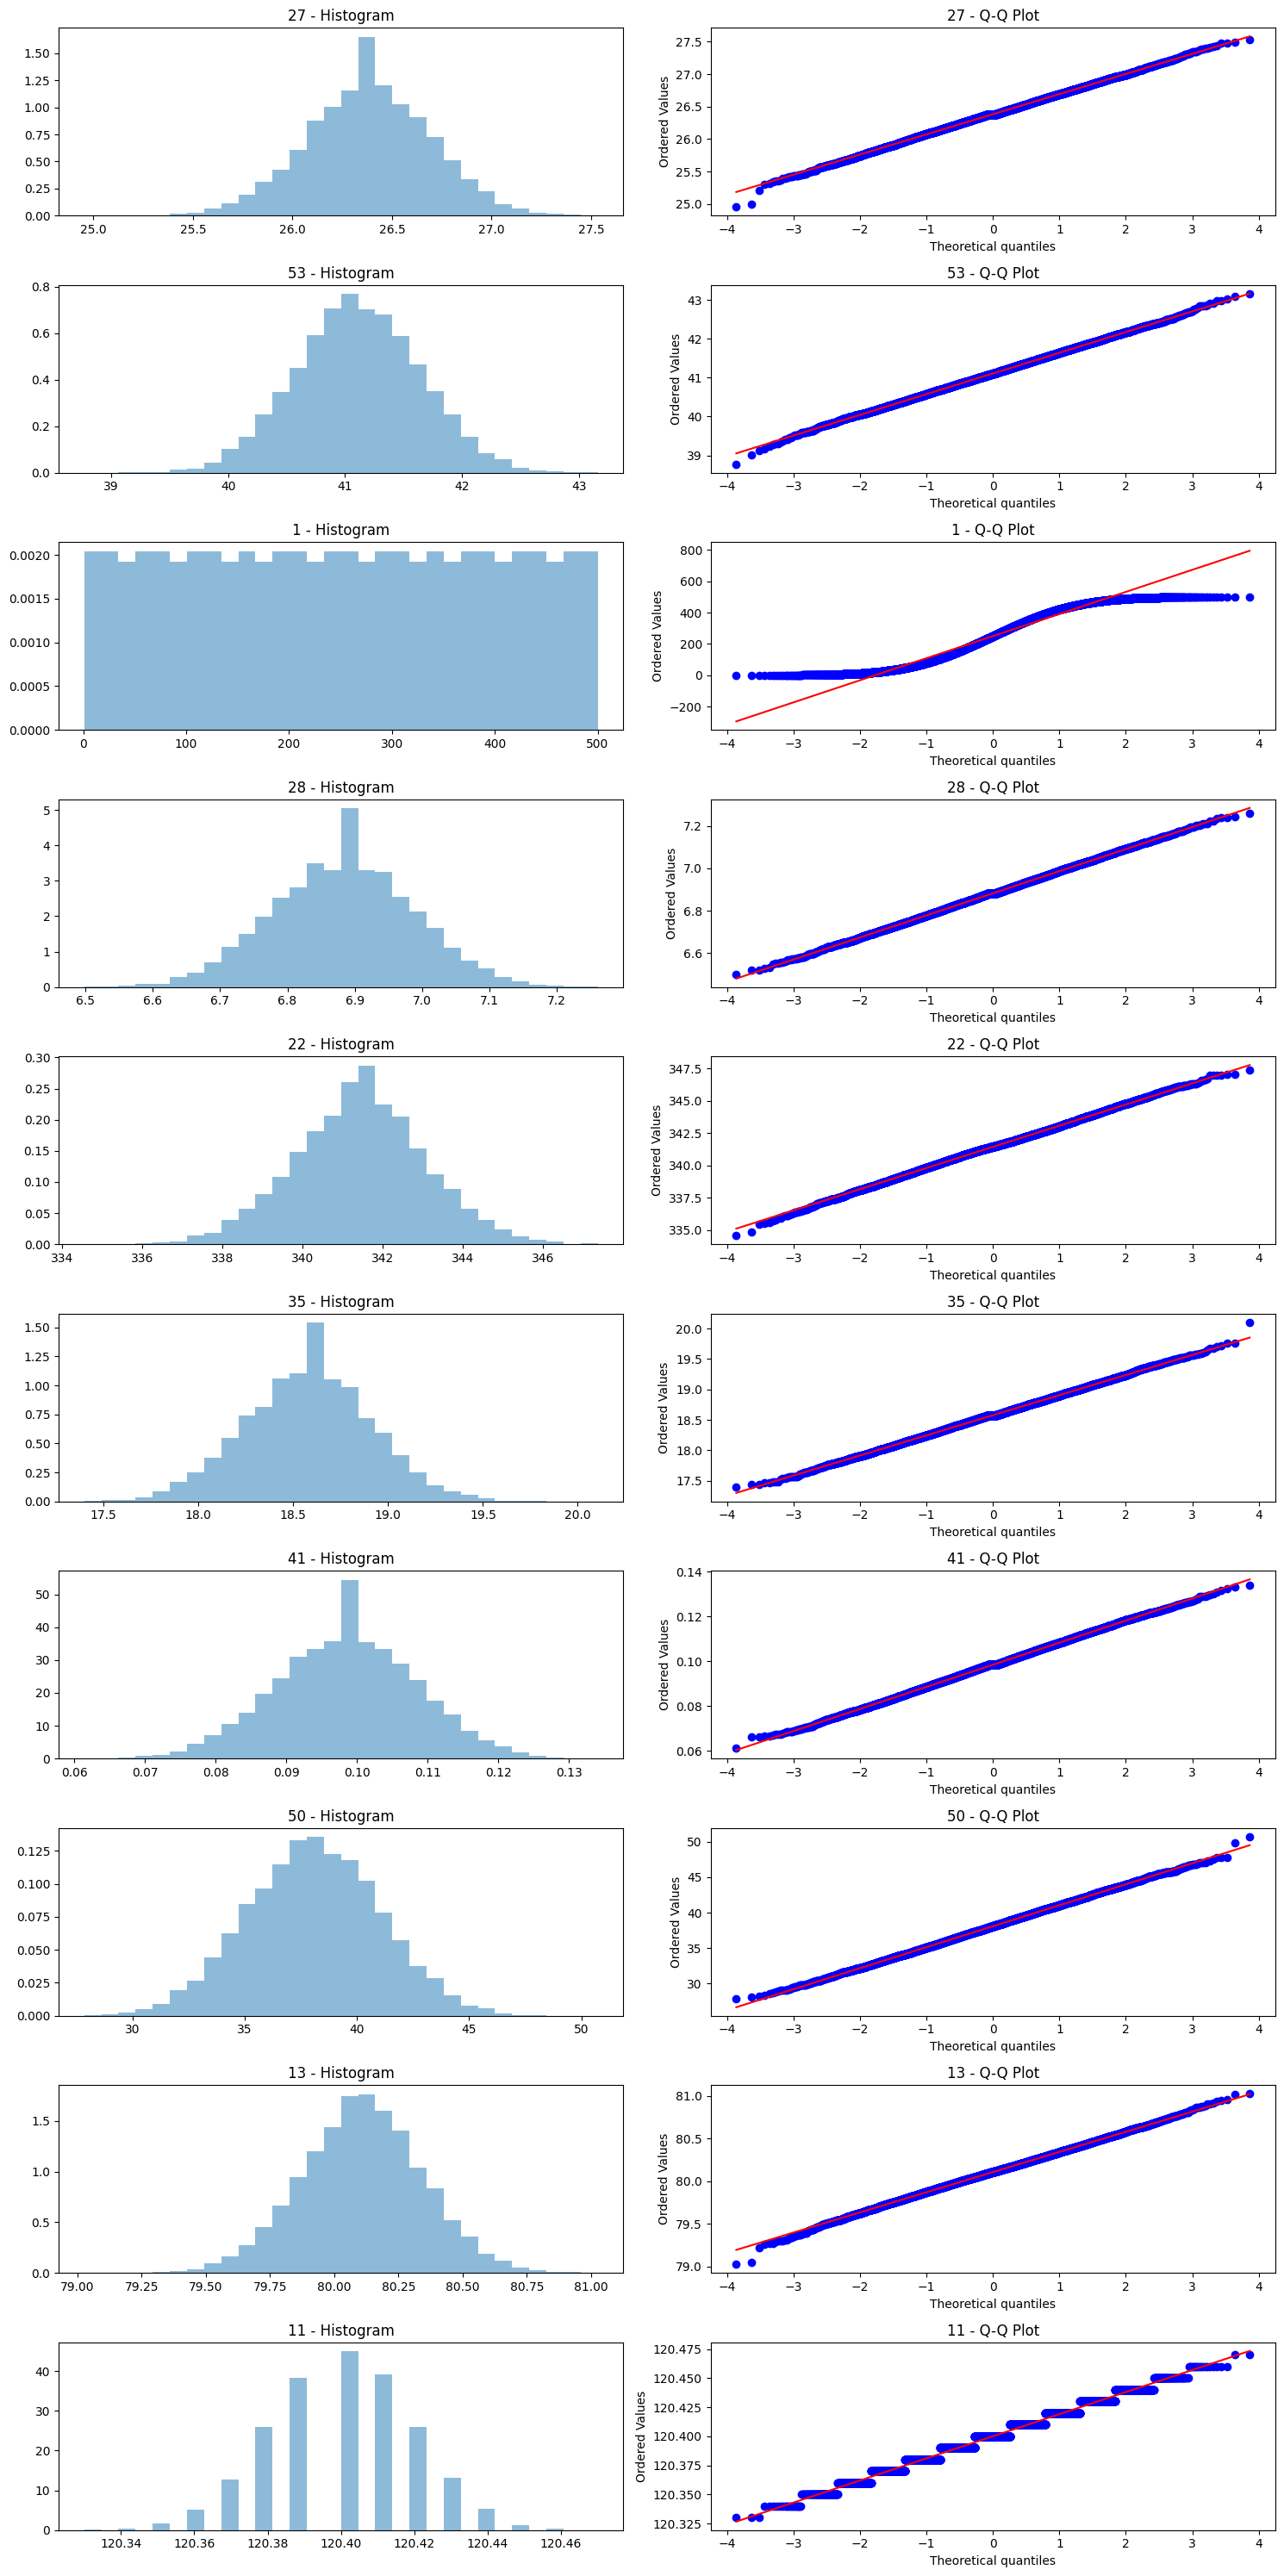

In [ ]:
# Sample data
np.random.seed(10)
data = np.random.randn(4, 55)

columns_to_test = np.random.choice(sampled_data_TEP_train_nofaults.shape[1], 10, replace=False)

# Create subplots for each column
fig, axes = plt.subplots(len(columns_to_test), 2, figsize=(15, 3 * len(columns_to_test)))

for i, column_name in enumerate(columns_to_test):
    # Histogram
    axes[i, 0].hist(sampled_data_TEP_train_nofaults.iloc[:, column_name], bins=30, density=True, alpha=0.5)
    axes[i, 0].set_title(f'{column_name} - Histogram')

    # Q-Q plot
    stats.probplot(sampled_data_TEP_train_nofaults.iloc[:,column_name], dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'{column_name} - Q-Q Plot')

plt.tight_layout()
plt.show()

In [ ]:
# Extract the data from the 3rd column onwards
data_to_normalize = training_data_all.iloc[:, 3:]

# Initialize the Standard Scaler
scaler = StandardScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(data_to_normalize)

# Replace the original data in the DataFrame with the normalized data
training_data_all.iloc[:, 3:] = normalized_data

# Print the first 3 columns and the first 100 rows of the normalized data
training_data_all.head()

<ipython-input-31-9d7f2b641e23>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  training_data_all.iloc[:, 3:] = normalized_data


,faultNumber,simulationRun,sample,1_A_Feed,2_D_Feed,3_E_Feed,4_Total_Feed,5_Recycle_flow,6_Reactor_feed_rate,7_Reactor_pressure,...,43_E_feed_flow,44_A_feed_flow,45_Total_feed_flow,46_Compressor_recycle_valve,47_Purge_valve,48_Separator_product_liquid_flow,49_Stripper_product_liquid_flow,50_Stripper_steam_valve,51_Reactor_cooling_water_flow,52_Condenser_cooling_water_flow
0,0,1.0,1.0,-0.073980,0.237757,0.206742,-0.364381,-0.049032,0.115501,-0.255940,...,-0.109826,-0.296145,-0.112240,-0.075585,0.000080,1.450104,0.565850,-0.183509,-0.076400,-0.089953
1,0,1.0,21.0,0.105293,-0.318174,-0.220336,-0.057254,-2.204635,0.615134,-0.291525,...,-0.072025,-0.150542,-0.369880,-0.110043,-0.039851,0.184843,0.109132,-0.228616,-0.044724,-0.119072
2,0,1.0,41.0,-0.033186,0.450522,-0.288180,-0.304063,-0.306671,1.509547,-0.358882,...,-0.052845,-0.276913,-0.073891,-0.131470,0.114295,-0.302738,-1.041407,-0.051260,-0.087345,0.096177
3,0,1.0,61.0,-0.105601,-2.265070,-0.013319,0.157943,0.247257,-0.402638,-0.281357,...,-0.198836,-0.309796,-0.560837,-0.059318,0.191703,-0.228510,-0.773601,0.021285,-0.182371,-0.127636
4,0,1.0,81.0,0.185661,0.736494,-0.242952,-0.331720,0.333139,0.066158,-0.263566,...,-0.071839,-0.102508,0.041158,-0.092114,0.147980,-0.857395,0.214462,-0.059930,-0.115340,0.164312


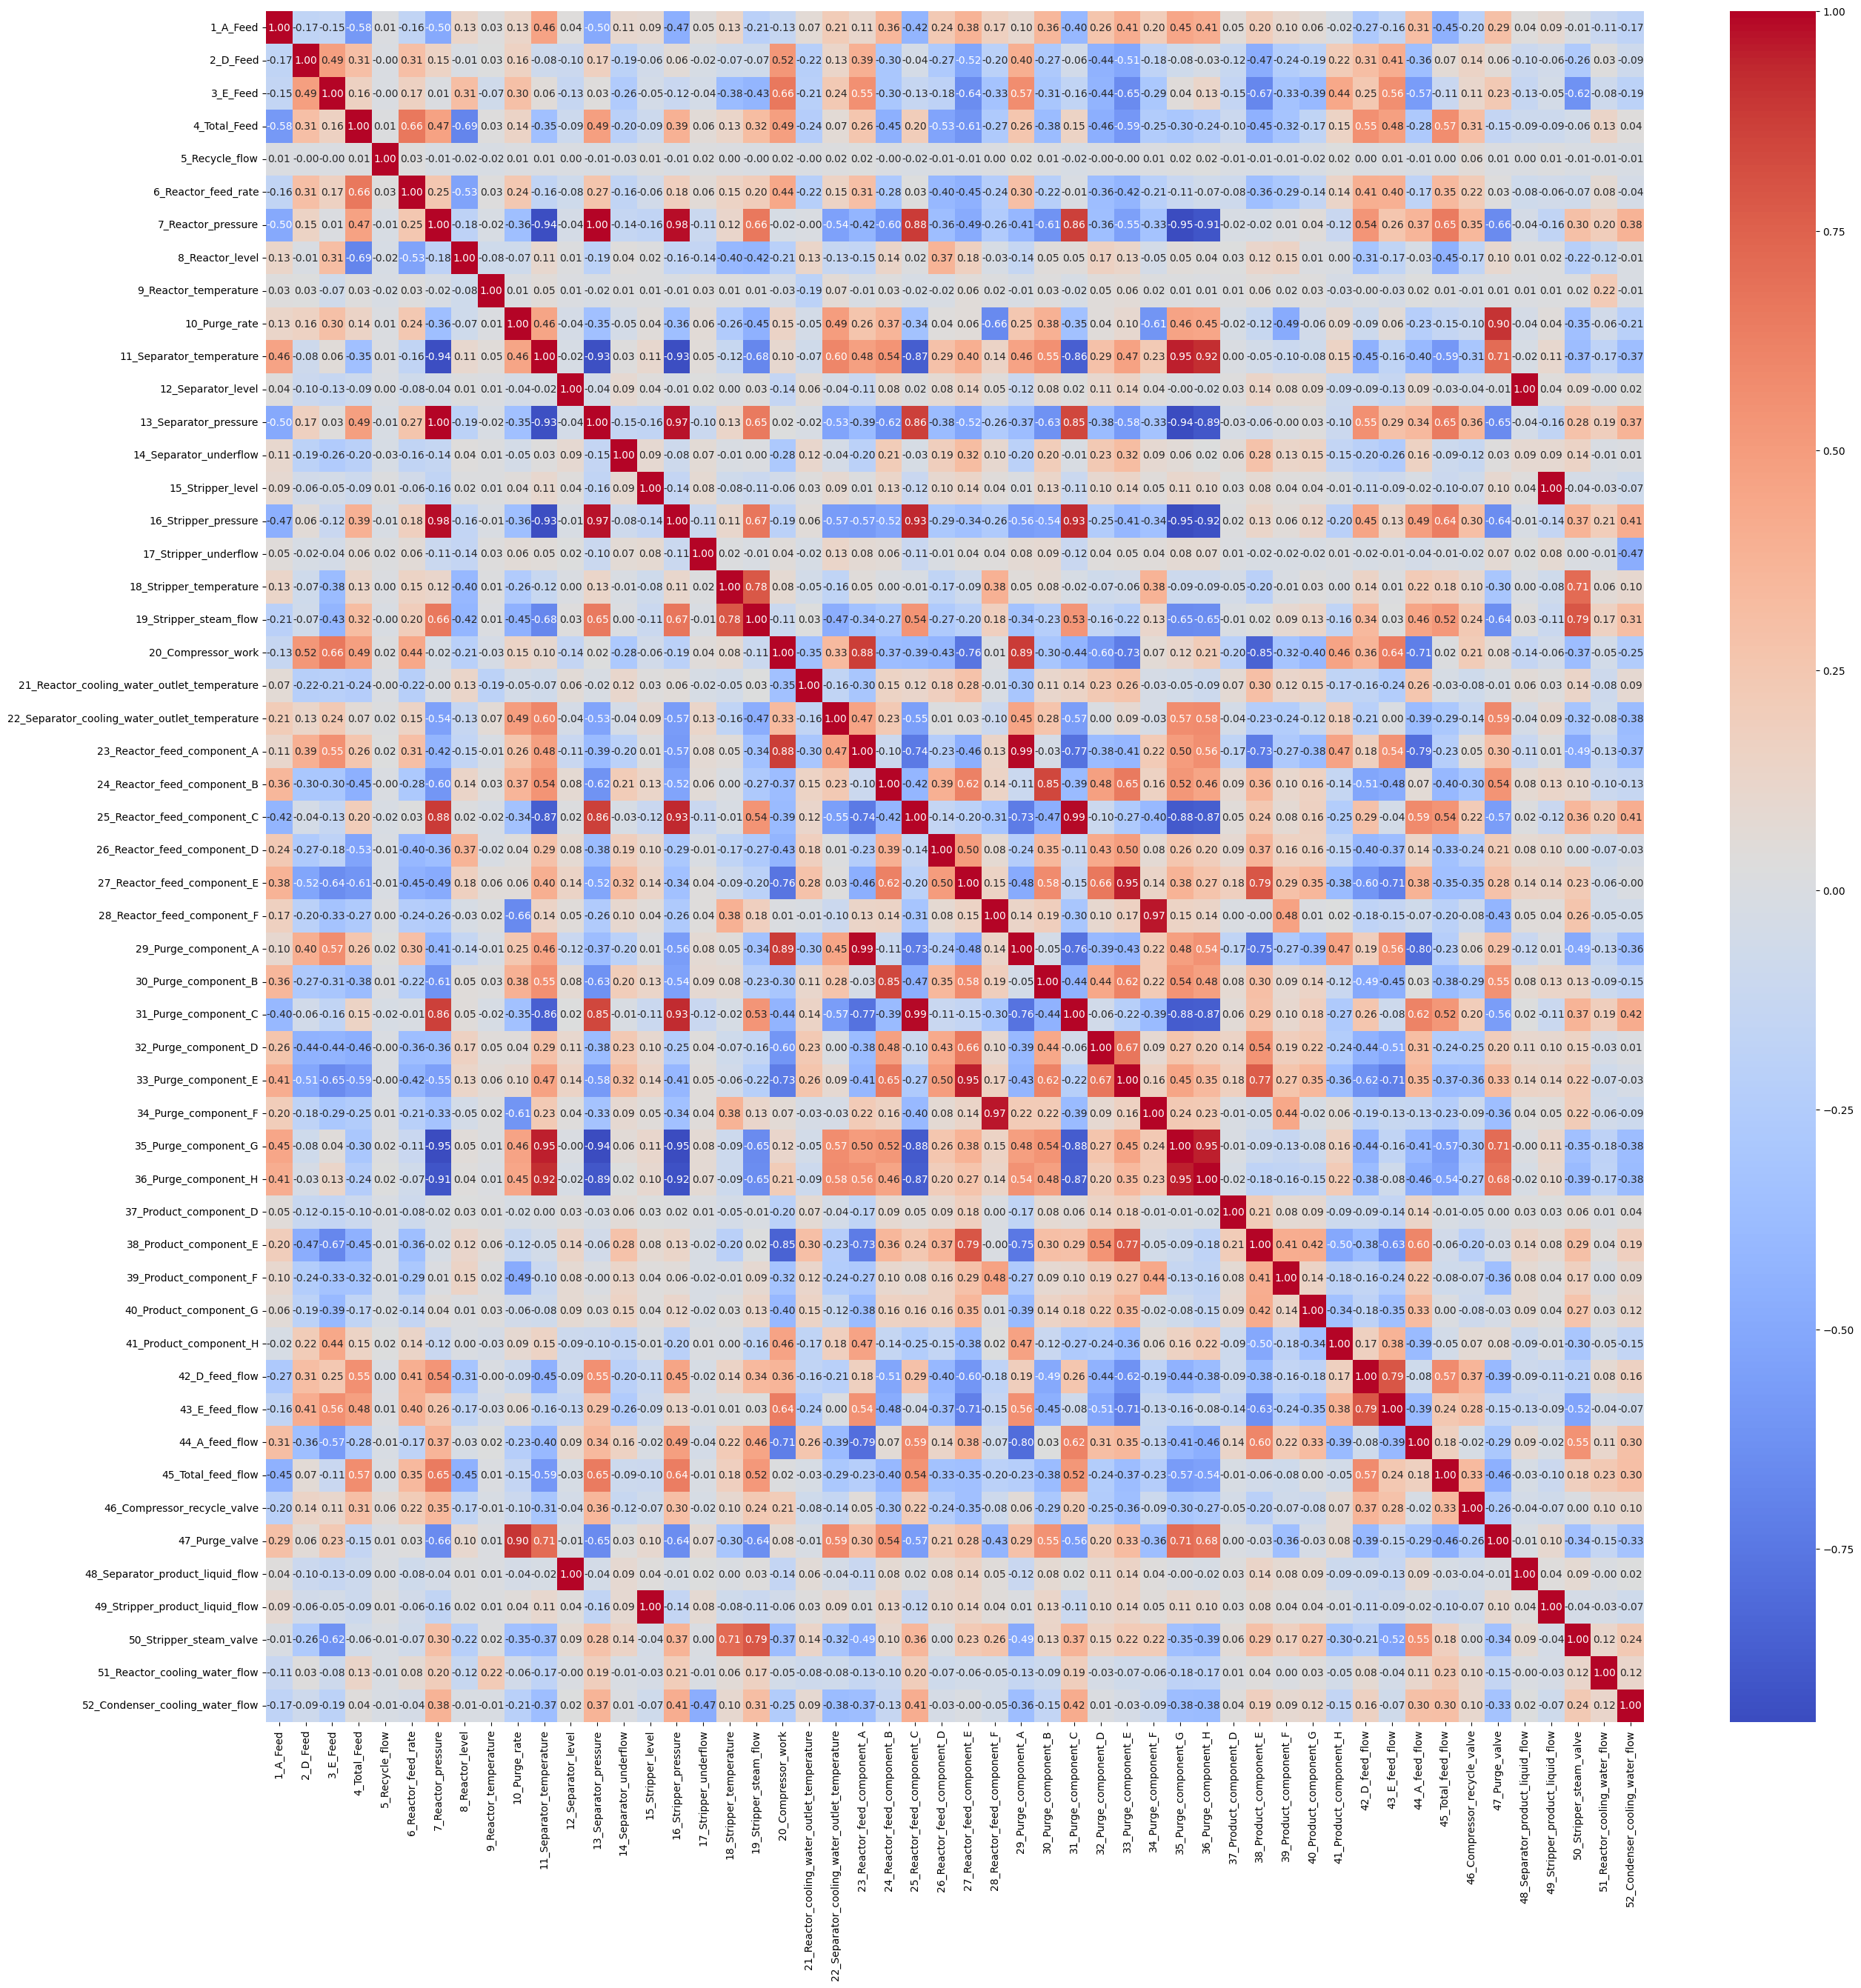

In [ ]:
# Calculate correlation matrix
correlation_matrix = training_data_all.iloc[:, 3:].corr()
# Plotting the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
# Extract the data from the 3rd column onwards
data_to_normalize = testing_data_all.iloc[:, 3:]

# Initialize the Standard Scaler
scaler = StandardScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(data_to_normalize)

# Replace the original data in the DataFrame with the normalized data
testing_data_all.iloc[:, 3:] = normalized_data

# Print the first 3 columns and the first 100 rows of the normalized data
testing_data_all.head()

<ipython-input-33-9d19755daa51>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  testing_data_all.iloc[:, 3:] = normalized_data


,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,1.0,1.0,-0.035775,0.160445,-0.389195,0.299942,0.680821,0.292362,-0.259734,...,-0.039009,-0.260799,-0.460151,-0.076897,0.069314,0.691708,0.656444,-0.137741,-0.001458,-0.453704
1,0,1.0,21.0,0.271574,0.791484,-0.206561,0.114932,-1.083564,-0.396102,-0.365161,...,-0.182755,-0.035563,-0.440087,-0.147741,0.197918,0.364975,0.850244,-0.127391,-0.065629,0.148734
2,0,1.0,41.0,0.024870,-1.346779,-0.390966,-0.307554,1.661525,-1.413586,-0.419691,...,-0.169413,-0.198911,-0.085113,-0.103567,0.179287,1.271997,1.127953,0.042096,-0.137468,-0.252782
3,0,1.0,61.0,-0.004337,-0.214092,0.160478,-0.354496,0.019727,0.051706,-0.342135,...,-0.027429,-0.226487,-0.083378,-0.077949,0.147535,-0.486910,-0.597081,0.166351,-0.077979,-0.208423
4,0,1.0,81.0,-0.215818,0.559953,-0.017719,0.067485,-0.890924,-0.326040,-0.386970,...,-0.191063,-0.386099,-0.282284,-0.135345,0.330147,-0.995727,1.967045,0.065534,-0.059979,-0.268221


Feature Selection using Lasso

In [ ]:
# Extract features (X) and target variable (y)
X = training_data_all.iloc[:, 3:].values
y = training_data_all.iloc[:, 0].values

In [ ]:
# lasso_model = Lasso(alpha=0.01)
# lasso_model.fit(X, y)

In [ ]:
# selected_features = np.array(new_column_names)[lasso_model.coef_ != 0].T
# print(selected_features.size)
# print("Selected Features:")
# for feature in selected_features:
#     print(feature)

In [ ]:
# threshold = 0.1
# selected_features = np.array(new_column_names)[np.abs(lasso_model.coef_) > threshold]
# print(selected_features.size)
# print("Selected Features:")
# for feature in selected_features:
#     print(feature)

In [ ]:
# Convert boolean condition to indices
# selected_indices = [i for i, feature in enumerate(new_column_names) if feature in selected_features]

In [ ]:
# # Mapping dictionary for faultNumber to new fault descriptions
# fault_mapping = {
#     0: 'No Fault',
#     1: 'A/C feed ratio, B composition constant',
#     2: 'B composition, A/C ratio constant',
#     3: 'Reactor cooling water inlet temperature',
#     4: 'Condenser cooling water inlet temperature',
#     5: 'A feed loss',
#     6: 'C header pressure loss-reduced availability',
#     7: 'A, B, C feed composition',
#     8: 'C feed temperature',
#     9: 'Reactor cooling water inlet temperature',
#     10: 'Condenser cooling water inlet temperature',
#     11: 'Reaction kinetics',
#     12: 'Reactor cooling water valve sticking',
#     13: 'Unknown',
#     14: 'Unknown',
#     15: 'Unknown',
#     16: 'Unknown',
#     17: 'Unknown',
#     18: 'The valve for stream 4 Constant position'
# }

# # Rename the fault descriptions in the training data
# training_data_all['faultNumber'] = training_data_all['faultNumber'].map(fault_mapping)

# # Rename the fault descriptions in the testing data
# testing_data_all['faultNumber'] = testing_data_all['faultNumber'].map(fault_mapping)

In [ ]:
# Split the data into training and validation sets with feature selection
#X_train, X_valid, y_train, y_valid = train_test_split(X[:, selected_indices], y, test_size = 0.2, random_state=42)

 # Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
# Extract features (X) and target variable (y)
X_test = torch.tensor(testing_data_all.iloc[:, 3:].values, dtype = torch.float32).to(device)
y_test = torch.tensor(testing_data_all.iloc[:, 0].values, dtype=torch.long).to(device)

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long).to(device)

In [ ]:
# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle =False)

In [ ]:
output_size = len(torch.unique(y_train_tensor))  # Number of classes

#FeedForward Neural Network:

Input layer: $x∈R^{n_{input}}$

Hidden layer: $h= σ(W_1x + b_1)$

Output layer: $y = σ(W_2​h + b_2)$

Here,

$x$ is the input vector.

$W_1$ and $W_2$ are weight matrices.

$b_1$ and $b_2$ are bias vectors.

$σ$ is the activation function (ReLU).


Cost Function:

$Cross \ Entropy \ Loss(y,\hat{y})=−\frac{1}{N}​∑^N_{i=1}​∑^K_{k=1}​y_{i,k}​log(\hat{y}_{i,k})$

In [ ]:
# Define the feedforward neural network model
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [ ]:
class FeedforwardNN2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FeedforwardNN2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [ ]:
# Instantiate the model
input_size = X_train.shape[1]  # Adjust based on your data

hidden_size_1st = [256, 256]
#hidden_size_2nd = [256, 256, 256]

output_size = len(torch.unique(y_train_tensor))  # Number of classes

#model = FeedforwardNN2(input_size, hidden_size_2nd[0], hidden_size_2nd[1], hidden_size_2nd[2], output_size).to(device)
model = FeedforwardNN(input_size, hidden_size_1st[0], hidden_size_1st[1], output_size).to(device)


print(model)

FeedforwardNN(
  (fc1): Linear(in_features=52, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=18, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.001)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        valid_outputs = model(X_valid_tensor)
        _, predicted = torch.max(valid_outputs, 1)
        accuracy = torch.sum(predicted == y_valid_tensor).item() / len(y_valid_tensor)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {accuracy:.4f}')

Epoch [1/10], Validation Accuracy: 0.7142
Epoch [2/10], Validation Accuracy: 0.7316
Epoch [3/10], Validation Accuracy: 0.7396
Epoch [4/10], Validation Accuracy: 0.7374
Epoch [5/10], Validation Accuracy: 0.7416
Epoch [6/10], Validation Accuracy: 0.7370
Epoch [7/10], Validation Accuracy: 0.7407
Epoch [8/10], Validation Accuracy: 0.7397
Epoch [9/10], Validation Accuracy: 0.7416
Epoch [10/10], Validation Accuracy: 0.7431


In [ ]:
# Test the final model on your test set if available
test_outputs = model(X_test)
_, predicted_test = torch.max(test_outputs, 1)
test_accuracy = torch.sum(predicted_test == y_test).item() / len(y_test)
print(f'Final Test Accuracy: {test_accuracy:.4f}')
# Test: 0.63

Final Test Accuracy: 0.6352


In [ ]:
#F1 Score for the Feedforward NNN
f1_score_FFNN = f1_score(y_test.cpu().numpy(), predicted_test.cpu().numpy(), average ='weighted')
print(f'F1 Score: {f1_score_FFNN:.2f}')
#F1 0.64

F1 Score: 0.64


In [ ]:
conf_matrix = confusion_matrix(predicted_test.cpu().numpy(), y_test.cpu().numpy(), normalize = 'true')

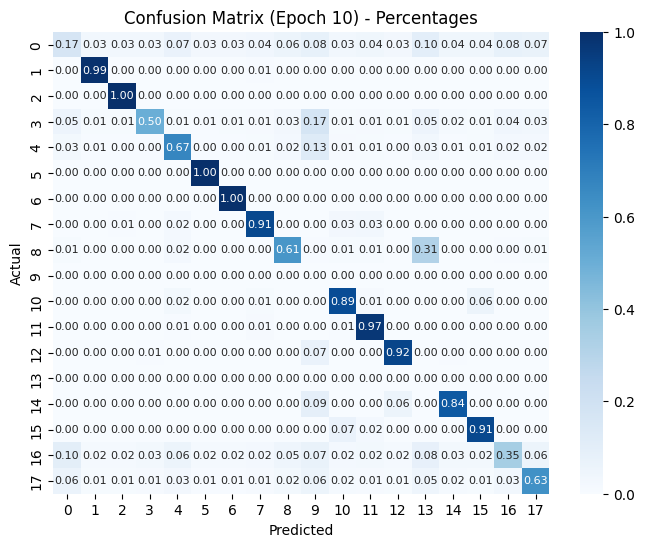

In [ ]:
# Plot Confusion Matrix as Heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=range(output_size), yticklabels=range(output_size), annot_kws={"size": 8})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Epoch {}) - Percentages'.format(num_epochs))
plt.show()

In [ ]:
from skorch.callbacks import EarlyStopping

In [ ]:
# Define the hyperparameter grid

# param_grid = {
#     'module__input_size': [input_size],
#     'module__output_size': [output_size],
#     'module__hidden_size1': [256],
#     'module__hidden_size2': [128],
#     'module__hidden_size3': [64],
#     'optimizer__lr': [0.01, 0.001, 0.1],
#     'optimizer__weight_decay': [0.001, 0.01, 0.1, 10],
# }

param_grid = {
    'module__input_size': [input_size],
    'module__output_size': [output_size],
    'module__hidden_size1': [256],
    'module__hidden_size2': [256],
    'optimizer__lr': [0.001, 0.01],
    'optimizer__weight_decay': [0.001, 0.01]}

In [ ]:
# net = NeuralNetClassifier(
#     module=FeedforwardNN,
#     criterion=torch.nn.CrossEntropyLoss,
#     optimizer=torch.optim.Adam,
#     callbacks=[EarlyStopping(patience=3)],
# )

# # Convert PyTorch tensors to NumPy arrays
# X_train_numpy = X_train_tensor.cpu().numpy()
# y_train_numpy = y_train_tensor.cpu().numpy()

# # Create GridSearchCV with the NeuralNetClassifier and the hyperparameter grid
# grid_search = GridSearchCV(net, param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), verbose=1)

# # Fit the grid search to your data
# grid_search.fit(X_train_numpy, y_train_numpy)

# Autoencoder Classifier


$Cross \ Entropy \ Loss(y,\hat{y})=−\frac{1}{N}​∑^N_{i=1}​∑^K_{k=1}​y_{i,k}​log(\hat{y}_{i,k})$

In [ ]:
# Define the Autoencoder with Classification
class AutoencoderWithClassification(nn.Module):
    def __init__(self, input_size, encoding_size, num_classes):
        super(AutoencoderWithClassification, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, encoding_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, input_size),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(encoding_size, num_classes)
        )

    def forward(self, x):
        encoding = self.encoder(x)
        reconstruction = self.decoder(encoding)
        classification = self.classifier(encoding)
        return reconstruction, classification

In [ ]:
# Instantiate the model
autoencoder_model = AutoencoderWithClassification(input_size=X_train.shape[1],
                                                  encoding_size=256,
                                                  num_classes= output_size).to(device)

# Print the model summary
print(autoencoder_model)

AutoencoderWithClassification(
  (encoder): Sequential(
    (0): Linear(in_features=52, out_features=256, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=52, bias=True)
    (1): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=18, bias=True)
  )
)


In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.001, weight_decay = 0.001)
#optimizer = optim.AdamW(autoencoder_model.parameters(), lr=0.001, weight_decay = 0.001)

In [ ]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    autoencoder_model.train()
    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        reconstructions, predictions = autoencoder_model(batch_data)
        reconstruction_loss = criterion(reconstructions, batch_data)
        classification_loss = criterion(predictions, batch_labels)
        total_loss = reconstruction_loss + classification_loss
        total_loss.backward()
        optimizer.step()

    # Evaluation on the validation set
    autoencoder_model.eval()
    all_predictions = []
    with torch.no_grad():
        for batch_data, batch_labels in valid_loader:
            _, predictions = autoencoder_model(batch_data)
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    # Calculate accuracy on the validation set
    accuracy = accuracy_score(y_valid, all_predictions)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {accuracy:.4f}')

Epoch [1/15], Validation Accuracy: 0.7116
Epoch [2/15], Validation Accuracy: 0.7412
Epoch [3/15], Validation Accuracy: 0.7539
Epoch [4/15], Validation Accuracy: 0.7669
Epoch [5/15], Validation Accuracy: 0.7696
Epoch [6/15], Validation Accuracy: 0.8132
Epoch [7/15], Validation Accuracy: 0.8199
Epoch [8/15], Validation Accuracy: 0.8222
Epoch [9/15], Validation Accuracy: 0.8246
Epoch [10/15], Validation Accuracy: 0.8269
Epoch [11/15], Validation Accuracy: 0.8231
Epoch [12/15], Validation Accuracy: 0.8290
Epoch [13/15], Validation Accuracy: 0.8239
Epoch [14/15], Validation Accuracy: 0.8310
Epoch [15/15], Validation Accuracy: 0.8268


In [ ]:
autoencoder_model.eval()
with torch.no_grad():
    _, test_predictions = autoencoder_model(X_test)

# Calculate accuracy on the test set
_, predicted_test = torch.max(test_predictions, 1)
test_accuracy = accuracy_score(y_test.cpu().numpy(), predicted_test.cpu().numpy())
print(f'Test Accuracy: {test_accuracy:.4f}')

#Test accuracy 0.7014 w L2 pennalty and adam
#test accuracy 0.6836 w L1 pennalty and AdamW

Test Accuracy: 0.6971


In [ ]:
#F1 Score for the Autoencoder
f1_score_auto = f1_score(y_test.cpu().numpy(), predicted_test.cpu().numpy(), average = 'weighted')
print(f'F1 Score: {f1_score_auto:.2f}')

#F1 score 0.72 w L2 pennalty and adam
#F1 0.71 w l1 pennalty and adamW

F1 Score: 0.73


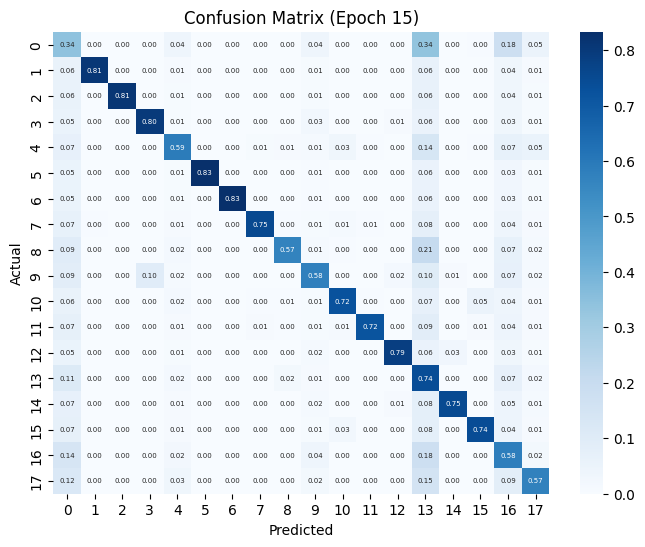

In [ ]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix
conf_matrix = confusion_matrix(y_test.cpu().numpy(), predicted_test.cpu().numpy(), normalize = 'true')

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=range(output_size), yticklabels=range(output_size),  annot_kws={"size": 5})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Epoch {})'.format(num_epochs))
plt.show()

# XGboost

XGboost


$Objective = ∑_{i=1}^N Loss(y_i, \hat{y}_i) + ∑ _{k=1}^K Ω(f_k)$

Tree: $\hat{y} = f(x;{split \ conditions,leaf \ values})$


Loss Function:


$Softmax \ Loss(y,\hat{y})= − \frac{1}{N}​∑^N_{i=1}​∑^K_{k=1} ​\hat{y}_{i,k} ​log\Big( \frac{e^{\hat{y}_{i,k}}} {∑_{j=1}^K ​e^{\hat{y}_{i,j}}}\Big)$

In [ ]:
# Instantiate the XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax',
                          num_class = output_size,
                          random_state=42,
                          learning_rate = 0.3,
                          gamma = 0,
                          subsample = 0.8,
                          colsample_bytree = 0.8,
                          reg_alpha = 1,
                          reg_lambda = 1,
                          max_depth = 8,
                          eval_metric = 'merror',
                          n_estimators = 200)

In [ ]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=18, num_parallel_tree=None, ...)

In [ ]:
# Predict on the validation set
y_pred = xgb_model.predict(X_valid)

In [ ]:
# Evaluate the model performance on the validation set
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy on the validation set: {accuracy:.4f}")
#0.9046

Accuracy on the validation set: 0.8575


In [ ]:
# Predict on the test set
y_pred_test = xgb_model.predict(X_test.cpu().numpy())

In [ ]:
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred_test)
print(f"Accuracy on the test set: {accuracy:.4f}")
#0.7316

Accuracy on the test set: 0.7361


In [ ]:
f1_score(y_test.cpu().numpy(), y_pred_test, average = 'weighted')
#F1 0.763

0.7722656866609462

In [ ]:
conf_matrix = confusion_matrix(y_test.cpu().numpy(), y_pred_test,  normalize = 'true')

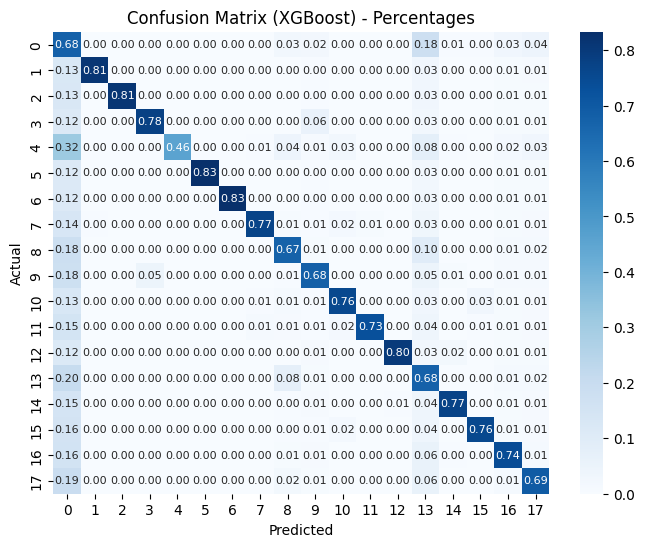

In [ ]:
# Plot Confusion Matrix as Heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=range(output_size), yticklabels=range(output_size), annot_kws={"size": 8})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost) - Percentages')
plt.show()

# Random Forest Classifier

In [ ]:
# Define and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200,
                                  max_depth=10,
                                  min_samples_split=10,
                                  min_samples_leaf=4,
                                  max_features='sqrt',
                                  max_leaf_nodes=None,
                                  bootstrap=True,
                                  criterion='gini',
                                  random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [ ]:
# Predict on the validation set
y_pred_val = rf_model.predict(X_valid)
# Evaluate the model
accuracy = accuracy_score(y_valid, y_pred_val)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.6913


In [ ]:
# Predict on the validation set
y_pred_test = rf_model.predict(X_test.cpu().numpy())
# Evaluate the model
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred_test)
print(f'Test Accuracy: {accuracy:.4f}')
#Test = 0.613

Test Accuracy: 0.6074


In [ ]:
f1_score(y_test.cpu().numpy(), y_pred_test, average = 'weighted')
#F1 0.651

0.6474674244032048

In [ ]:
conf_matrix = confusion_matrix(y_test.cpu().numpy(),  y_pred_test, normalize = 'true')

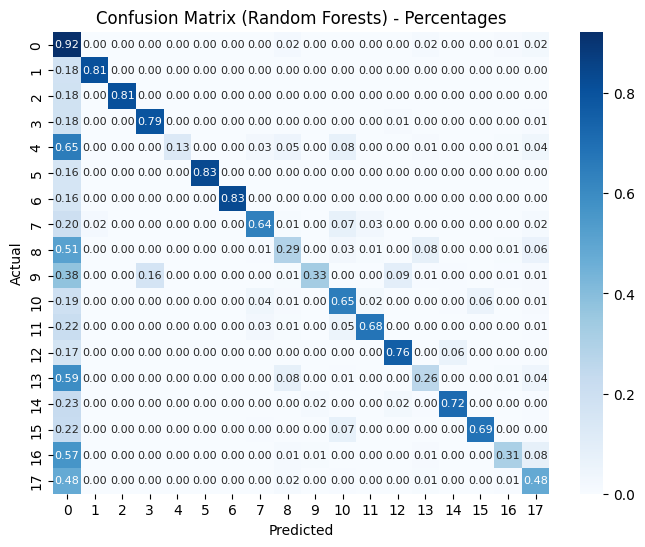

In [ ]:
# Plot Confusion Matrix as Heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=range(output_size), yticklabels=range(output_size), annot_kws={"size": 8})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forests) - Percentages')
plt.show()